## Basic operations with Atmospheric data on native grid
## TCo1279 - unstructured


In [2]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/eunbyeol/MPI/scheduler.json')  
client

<Client: 'tcp://203.247.189.225:37629' processes=7 threads=126, memory=586.73 GiB>

In [3]:
import xarray as xr
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm 

## Native grid

In [5]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '2080C'
realm = 'oifs'
base_f = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"


In [6]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '1950C'
realm = 'oifs'
base_p = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"

## Figure folder

In [7]:
import os

folder_name = "../figure_Hackathon2025_AG/step02_1279"     # figure folder         
save_dir = os.path.join(os.getcwd(), folder_name)  
os.makedirs(save_dir, exist_ok=True)    

In [8]:
files = glob.glob(os.path.join(base_f, "*.nc"))

unique_vars = set()

pattern = re.compile(r"atm_reduced_(.+?)_(?:\d+[hdm](?:_pl)?)_\d{6}-\d{6}\.nc$")

for f in files:
    fname = os.path.basename(f)
    m = pattern.match(fname)
    if m:
        unique_vars.add(m.group(1))
result_list = sorted(unique_vars)
print(result_list)

['1d_10u', '1d_10v', '1d_2t', '1d_msl', '1d_ssr', '1d_str', '1d_tcc', '1d_tsr', '1d_tsrc', '1d_ttr', '1m_pl_cc', '1m_pl_clwc', '1m_swvl2', '3h_10u', '3h_10v', '3h_2t', '3h_cp', '3h_ewss', '3h_hcc', '3h_lcc', '3h_lsp', '3h_mcc', '3h_msl', '3h_nsss', '3h_pl_cc', '3h_pl_ciwc', '3h_pl_clwc', '3h_pl_q', '3h_pl_r', '3h_pl_t', '3h_pl_u', '3h_pl_v', '3h_pl_vo', '3h_pl_w', '3h_pl_z', '3h_tcc', '3h_tsr', '3h_tsrc']


In [9]:
# -------------------
# Get file list
# -------------------
files_f = os.listdir(base_f)
files_p = os.listdir(base_p)

In [10]:
# -----------------------
# Target variable for AG
# -----------------------
# target = "1d_2t"
# target = "1d_cp"
# target = "1d_lsp"
# target = "1d_10u"
# target = "1d_10v"

# -------------------
# Target period
# -------------------
p_start_year = 1951
p_end_year = 1952
f_start_year = 2091
f_end_year = 2092


In [11]:
# -------------------
# 1) YEAR RANGE FUNCTION (FIXED)
# -------------------
def extract_year_range(fname):
    m = re.search(r'_(\d{6})-(\d{6})\.nc$', fname)
    if m:
        y1 = int(m.group(1)[0:4])
        y2 = int(m.group(2)[0:4])
        return y1, y2
    return None, None   

In [12]:
def select_files(files, base, target, start_year, end_year):
    selected = [
        os.path.join(base, f)
        for f in sorted(files) if target in f
        for y1, y2 in [extract_year_range(f)]
        if y1 is not None and (y2 >= start_year) and (y1 <= end_year)
    ]
    return selected

In [13]:
def open_dataset(files):
    ds = xr.open_mfdataset(files, combine='by_coords', parallel=True, chunks={"time": 100})
    print(ds.dims)
    print(ds.data_vars)
    return ds


In [14]:
def select_variable(ds, var_key, start_year, end_year):
    """Select variable from dataset and slice by time."""
    if var_key not in ds:
        raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")
    
    da = ds[var_key]
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    da_sel = da.sel({time_dim: slice(f"{start_year}-01-01", f"{end_year}-12-31")})
    
    return da_sel

In [15]:
def compute_mean(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.mean(dim=time_dim).compute()

In [16]:
def compute_std(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.std(dim=time_dim).compute()

In [17]:
def compute_std_anomaly(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    
    # remove leaf day
    da_noleap = da.sel({time_dim: ~((da[time_dim].dt.month==2) & (da[time_dim].dt.day==29))})
    
    # daily climatology
    clim = da_noleap.groupby(f"{time_dim}.dayofyear").mean(dim=time_dim)
    
    # anomaly
    anom = da_noleap.groupby(f"{time_dim}.dayofyear") - clim
    
    # std
    from dask.diagnostics import ProgressBar
    with ProgressBar():
        return anom.std(dim=time_dim).compute()


In [18]:
def open_and_select(files, base, target, start_year, end_year):
    var_key = target.split("_", 1)[1]
    sel_files = select_files(files, base, target, start_year, end_year)
    # print(f"Selected files for {target} ({start_year}-{end_year}):", sel_files)
    print(f"Selected files for {target} ({start_year}-{end_year}):")

    ds = open_dataset(sel_files)
    da = select_variable(ds, var_key, start_year, end_year)
    return da

In [20]:
# -------------------
# CP
# -------------------
target_cp = "3h_cp"
var_key_cp = target_cp.split("_", 1)[1]   # "2t"

# ---- Load data (p, f separately) ----
da_p_cp_3h = open_and_select(files_p, base_p, target_cp, p_start_year, p_end_year)
da_f_cp_3h = open_and_select(files_f, base_f, target_cp, f_start_year, f_end_year)

# -------------------
# make daily results
# -------------------
da_p_cp = da_p_cp_3h.resample(time_counter='1D').sum()
da_f_cp = da_f_cp_3h.resample(time_counter='1D').sum()


Selected files for 3h_cp (1951-1952):
FrozenMappingWarningOnValuesAccess({'time_counter': 5848, 'cell': 6599680, 'nvertex': 4, 'axis_nbounds': 2})
Data variables:
    bounds_lon           (time_counter, cell, nvertex) float32 618GB dask.array<chunksize=(248, 6599680, 4), meta=np.ndarray>
    bounds_lat           (time_counter, cell, nvertex) float32 618GB dask.array<chunksize=(248, 6599680, 4), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 94kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 94kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    cp                   (time_counter, cell) float32 154GB dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Selected files for 3h_cp (2091-2092):
FrozenMappingWarningOnValuesAccess({'time_counter': 5848, 'cell': 6599680, 'nvertex': 4, 'axis_nbounds': 2})
Data variables:
    bounds_lon           (time_counter, cell, nvertex) float32 618GB d

In [21]:
# -------------------
# lsp
# -------------------
target_lsp = "3h_lsp"
var_key_lsp = target_lsp.split("_", 1)[1]   # lap

# ---- Load data (p, f separately) ----
da_p_lsp_3h = open_and_select(files_p, base_p, target_lsp, p_start_year, p_end_year)
da_f_lsp_3h = open_and_select(files_f, base_f, target_lsp, f_start_year, f_end_year)

# -------------------
# make daily results
# -------------------
da_p_lsp = da_p_lsp_3h.resample(time_counter='1D').sum()
da_f_lsp = da_f_lsp_3h.resample(time_counter='1D').sum()


Selected files for 3h_lsp (1951-1952):
FrozenMappingWarningOnValuesAccess({'time_counter': 5848, 'cell': 6599680, 'nvertex': 4, 'axis_nbounds': 2})
Data variables:
    bounds_lon           (time_counter, cell, nvertex) float32 618GB dask.array<chunksize=(248, 6599680, 4), meta=np.ndarray>
    bounds_lat           (time_counter, cell, nvertex) float32 618GB dask.array<chunksize=(248, 6599680, 4), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] 94kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 94kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lsp                  (time_counter, cell) float32 154GB dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Selected files for 3h_lsp (2091-2092):
FrozenMappingWarningOnValuesAccess({'time_counter': 5848, 'cell': 6599680, 'nvertex': 4, 'axis_nbounds': 2})
Data variables:
    bounds_lon           (time_counter, cell, nvertex) float32 618GB

In [22]:
# ---- Compute mean ----
da_mean_p_cp = compute_mean(da_p_cp)
da_mean_f_cp = compute_mean(da_f_cp)

# ---- Compute std with anomaly ----
da_std_ano_p_cp = compute_std_anomaly(da_p_cp)
da_std_ano_f_cp = compute_std_anomaly(da_f_cp)
# ---- Compute std ----
da_std_p_cp = compute_std(da_p_cp)
da_std_f_cp = compute_std(da_f_cp)

In [23]:
# ---- Compute mean ----
da_mean_p_lsp = compute_mean(da_p_lsp)
da_mean_f_lsp = compute_mean(da_f_lsp)

# ---- Compute std with anomaly ----
da_std_ano_p_lsp = compute_std_anomaly(da_p_lsp)
da_std_ano_f_lsp = compute_std_anomaly(da_f_lsp)

# ---- Compute std ----
da_std_p_lsp = compute_std(da_p_lsp)
da_std_f_lsp = compute_std(da_f_lsp)

## Figures

In [24]:
long_name_cp = da_p_cp.attrs.get("long_name", None)
print(long_name_cp)

long_name_lsp = da_p_lsp.attrs.get("long_name", None)
print(long_name_lsp)

Convective precipitation
Large-scale precipitation


In [26]:
lat = da_mean_p_cp['lat'].values  
lon = da_mean_p_cp['lon'].values 

In [27]:
# mean - only CP
hist_cp = da_mean_p_cp.values*1000           
fut_cp = da_mean_f_cp.values*1000
diff_cp = fut_cp - hist_cp

# mean - only lsP
hist_lsp = da_mean_p_lsp.values*1000           
fut_lsp  = da_mean_f_lsp.values*1000
diff_lsp = fut_lsp - hist_lsp

# mean - TP = cp+lsP
hist_tp = hist_cp + hist_lsp        
fut_tp  = fut_cp + fut_lsp
diff_tp = fut_tp - hist_tp
long_name='Total Precipitation'

Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/step02_1279/cp_mean_TCo1279-DART.png


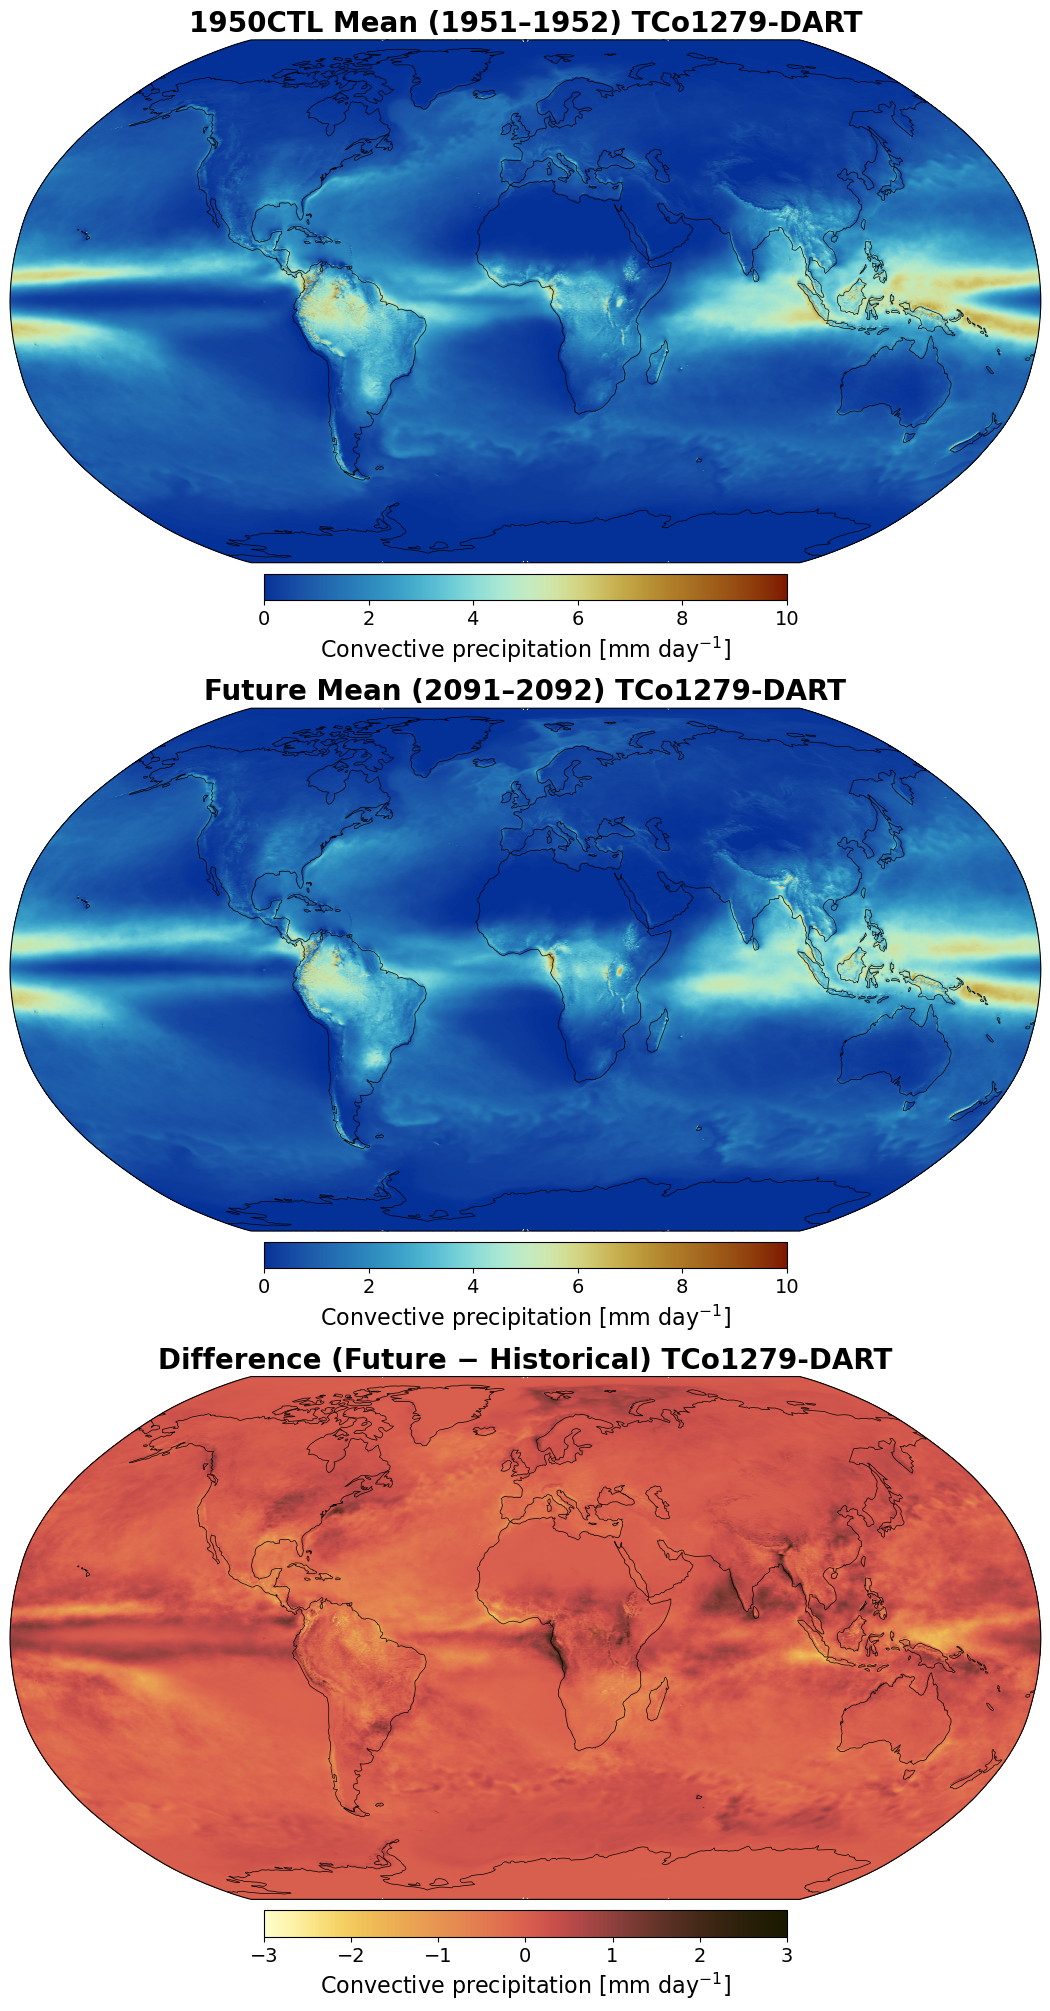

In [29]:
# CP
hist = hist_cp          
fut  = fut_cp
diff = fut - hist
long_name = long_name_cp
var_key = var_key_cp

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'1950CTL Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]

fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=1,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

In [ ]:
# LSP
hist = hist_lsp           
fut  = fut_lsp
diff = fut - hist
long_name = long_name_lsp
var_key = var_key_lsp

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'1950CTL Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=1,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

In [ ]:
# Total 
hist = hist_tp         
fut  = fut_tp
diff = fut - hist
long_name='Total Precipitation'
var_key = 'TP'

c_ranges = [(0, 10), (0, 10), (-3, 3)]

datasets = [hist, fut, diff]
titles = [
    f'1950CTL Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=1,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## STD

In [ ]:
# ---- Compute std with anomaly ----
da_p_tp = da_p_lsp + da_p_cp
da_f_tp = da_f_lsp + da_f_cp
da_std_ano_p_tp = compute_std_anomaly(da_p_tp)
da_std_ano_f_tp = compute_std_anomaly(da_f_tp)


In [ ]:
# Total 
hist = da_std_ano_p_tp         
fut  = da_std_ano_f_tp
hist = hist*1000
fut = fut*1000
diff = fut - hist
long_name='Total Precipitation'
var_key = 'TP'

c_ranges = [(0, 15), (0, 15), (-10, 10)]

datasets = [hist, fut, diff]
titles = [
    f'1950CTL Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid 만들기
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    
    sc = ax.scatter(
        lon,
        lat,
        c=data,
        s=1,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16')

save_path = os.path.join(save_dir, f"{var_key}_std_{expid}.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

In [ ]:
## STD - Region

In [ ]:
left, right = 65, 105
bottom, top = 0, 40

c_ranges = [(0, 15), (0, 15), (-10, 10)]
datasets = [hist, fut, diff]

fig, axes = plt.subplots(
    3, 1,
    figsize=(10, 30),
    subplot_kw={'projection': ccrs.PlateCarree()},  # 또는 LambertConformal
    constrained_layout=True
)

lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())  # 영역 제한
    ax.coastlines(linewidth=0.5)
    
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',
        cmap = cm.lajolla_r if "Difference" in title else cm.roma_r 
    )

    # 위경도 눈금 표시
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False     # 상단 눈금 제거
    gl.right_labels = False   # 오른쪽 눈금 제거
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.01, shrink=0.85, fraction=0.1,aspect=30)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label( f"{long_name} [mm day$^{{-1}}$]" if title != "Difference (Future − Historical)" else "ΔT (°C)",
                   size='16')

save_path = os.path.join(save_dir, f"{var_key}_std_{expid}_Himalaya.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")
plt.show()
